<a href="https://colab.research.google.com/github/egorssed/Lensed_Source_modelling_research/blob/main/Beta_VAE_Controlled_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
Folder='/content/drive/My Drive/Lensed Source modelling research/'

import sys
import os
sys.path.append(Folder+'/Modules')
import Image_Stats
import Visual_analysis

image_size=64
batch_size = 32
latent_dim = 64
start_lr = 1e-6

x = np.linspace(0, 64, 64)
y = np.linspace(0, 64, 64)
X, Y = np.meshgrid(x, y)
xdata = np.vstack((X.ravel(), Y.ravel()))

Mounted at /content/drive


### Prepare the data

In [2]:
from sklearn.model_selection import train_test_split

#We normalize the data to [0,1]
#Initial minI and maxI are stored in the Dataset_labels
#All the negative values set to 0 during preprocessing
def normalize_image(images):
    #Normalize image to [0,1]
    for i in range(len(images)):
        images[i][images[i]<0]=0
        images[i]=images[i]/images[i].max()
    return images

#Read the images and the features from the google drive
galaxy_images=np.load(Folder+'Data/Images_Filtered_Rotated.npy')
df=pd.read_csv(Folder+'Data/Labels_Filtered.csv',index_col=0)

#Bring images to a proper tensorial form
Size_of_dataset=len(galaxy_images[:-(len(galaxy_images)%batch_size)])
Number_of_batches=Size_of_dataset//batch_size
df=df.iloc[:Size_of_dataset]
galaxy_images=galaxy_images[:Size_of_dataset]

#Bring images to a proper tensorial form
gal_dataset_images=np.reshape(normalize_image(galaxy_images), (len(galaxy_images), galaxy_images.shape[1], galaxy_images.shape[2], 1))

#Separate the features we are eager to predict in the latent space
#Features=['Sersic_HLR', 'Sersic_n', 'Sersic_q','Sersic_phi']

#Extract test dataset
x_train, x_test ,y_train,y_test= train_test_split(gal_dataset_images.astype('float32'),df, test_size=round(0.05*Number_of_batches)*batch_size,random_state=42)
#Extract train and validation datasets
x_train, x_val , y_train, y_val= train_test_split(x_train,y_train, test_size=round(0.05*Number_of_batches)*batch_size,random_state=42)
#All the sets have number of galaxies which is a multiple of the batch size (32)
#The random_state is fixed so the split is reproducible yet random

### VAE 

#### libraries

In [3]:
import tensorflow as tf
from keras.layers import Input, Dense, BatchNormalization,Flatten,Reshape,Lambda,Conv2D,Conv2DTranspose,LeakyReLU
from keras.models import Model
from keras.optimizers import Adam
from keras import initializers
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops,smart_cond
import keras.backend as K

#### encoder

In [4]:
def encoder_function(input_img):
    #He initialization for Relu activated layers
    Heinitializer = initializers.HeNormal()

    x = Conv2D(filters=64, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(input_img)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=128, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=256, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=512, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=4096, kernel_size=4, strides=1,padding='valid',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Flatten()(x)
    
    
    #Predict mean of standard distribution and logarithm of variance
    Xavierinitializer=initializers.GlorotNormal()

    z_mean = Dense(latent_dim,kernel_initializer=initializers.Constant(value=0),bias_initializer=initializers.Constant(value=0))(x)
    z_log_var = Dense(latent_dim, kernel_initializer=initializers.Constant(value=0),bias_initializer=initializers.Constant(value=0))(x)

    return z_mean,z_log_var

#### decoder

In [5]:
def get_decoder(activation):
  def decoder_function(z):
    #He initialization for Relu activated layers
    Heinitializer = initializers.HeNormal()

    x = Reshape(target_shape=(1, 1, 64))(z)
    
    x = Conv2DTranspose(filters=512, kernel_size=4, strides=1,padding='valid',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(filters=256, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(filters=128, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(filters=64, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    #Xavier intialization for differentiable functions activated layers
    Xavierinitializer=initializers.GlorotNormal()
    if activation=='':
      decoded = Conv2DTranspose(filters=1, kernel_size=4, strides=2,padding='same',use_bias=False
                                ,kernel_initializer=Xavierinitializer)(x)
    else:
      decoded = Conv2DTranspose(filters=1, kernel_size=4, strides=2,padding='same',use_bias=False,
                              activation=activation,kernel_initializer=Xavierinitializer)(x)
  
    return decoded
  return decoder_function

#### loss

Decorators meant to create loss functions with given hyperparameters

In [17]:
def get_reconstruction_loss(loss_type='chi_sq'):

  #Chose original loss function
  if (loss_type=='chi_sq') or (loss_type=='mse'):
      loss_function=tf.math.squared_difference
  if loss_type=='binary_crossentropy':
      loss_function=K.binary_crossentropy

  def reconstruction_loss_function(y_true,y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    reconstruction_loss=loss_function(y_true,y_pred)

    #cast mse to chi_square by adding weights
    if (loss_type=='chi_sq'):
      #Poisson weights (sigma=sqrt(image))
      weights=tf.math.pow(tf.sqrt(tf.abs(y_true)+1e-5),-1)
      weights= math_ops.cast(weights, y_pred.dtype)
      reconstruction_loss=reconstruction_loss*weights
    
    return K.sum(reconstruction_loss,axis=-1)
  
  return reconstruction_loss_function

def get_regularization_loss(gamma=None):

  #Capacity is a global variable that is changed during training
  def regularization_loss_function(mean,logvar):
    #global Capacity
    #global beta_vae
    KL_loss=0.5 * K.sum(K.exp(logvar)+K.square(mean)-1-logvar, axis=-1)
    if (gamma is not None) and (Capacity is not None):  
      return gamma*tf.abs(KL_loss-Capacity)
    else:
      return beta_vae*KL_loss
  
  return regularization_loss_function

In [18]:
def get_model_loss(loss_type='chi_sq',gamma=None):

  reconstruction_loss_function=get_reconstruction_loss(loss_type)
  regularization_loss_function=get_regularization_loss(gamma)

  def model_loss_function(x,decoded):

    #KL divergence regularization quality
    mean = models['z_meaner'](x)
    logvar=models['z_log_varer'](x)
    regularization_loss=regularization_loss_function(mean,logvar)
    #reconstruction quality
    flattened_x=K.reshape(x,shape=(len(x),image_size*image_size))
    flattened_decoded=K.reshape(decoded,shape=(len(decoded),image_size*image_size))
    reconstruction_loss=reconstruction_loss_function(flattened_x,flattened_decoded)

    Beta_VAE_Loss=(reconstruction_loss+regularization_loss)/image_size/image_size
    return Beta_VAE_Loss

  return model_loss_function,reconstruction_loss_function,regularization_loss_function

#### vae class

In [24]:
def create_vae(activation='softplus',loss_type='chi_sq',gamma=None):

    #Reparametrization trick
    def reparameterize(args):
      mean,logvar=args
      eps = tf.random.normal(shape=mean.shape)
      return eps * tf.exp(logvar/2) + mean
    decoder_function=get_decoder(activation)
    model_loss_function,reconstruction_loss_function,regularization_loss_function=get_model_loss(loss_type,gamma)


    #VAE
    models = {}

    #Encoder
    input_img = Input(batch_shape=(batch_size, image_size, image_size, 1))

    z_mean, z_log_var=encoder_function(input_img)

    l=Lambda(reparameterize, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model(input_img, l, name='Encoder') 
    models["z_meaner"] = Model(input_img, z_mean, name='Enc_z_mean')
    models["z_log_varer"] = Model(input_img, z_log_var, name='Enc_z_log_var')

    #Decoder
    z = Input(shape=(latent_dim, ))
    decoded=decoder_function(z)

    models["decoder"] = Model(z, decoded, name='Decoder')
    models["vae"]     = Model(input_img, models["decoder"](models["encoder"](input_img)), name="VAE")

    return models,model_loss_function,reconstruction_loss_function,regularization_loss_function

In [25]:
def get_Neural_Network(activation='softplus',loss_type='chi_sq',gamma=None):
  with tf.device('/device:GPU:0'):
    models,model_loss_function,reconstruction_loss_function,regularization_loss_function =create_vae(activation,loss_type,gamma)

    models["vae"].compile(optimizer=Adam(learning_rate=start_lr, beta_1=0.5, beta_2=0.999,clipvalue=1), loss=model_loss_function)

    return models,model_loss_function,reconstruction_loss_function,regularization_loss_function

### Load model

In [50]:
beta_start=0
beta_vae=beta_start
beta_speed=1e-3
gamma=None
Start_Capacity=20
Capacity_speed=10
activation='softplus'
loss_type='chi_sq'

In [51]:
Checkpoint_to_load=0
Checkpoint_name='Models/Capacity_control/Chi_sq_Softplus_start_beta=0_beta_speed=1e-3/'
Checkpoints_Folder=Folder+Checkpoint_name

Capacity=Start_Capacity+(Checkpoint_to_load)*Capacity_speed
beta_vae=beta_start+(Checkpoint_to_load)*beta_speed


models,model_loss_function,reconstruction_loss_function,regularization_loss_function=get_Neural_Network(activation,loss_type,gamma)

Checkpoint_to_load_start=123
Checkpoints_Folder_start=Folder+'Models/Capacity_control/Chi_sq_Softplus_beta=0/'
models['vae'].load_weights(Checkpoints_Folder_start+'epoch_{}/Model'.format(Checkpoint_to_load_start))

if Checkpoint_to_load==0:
  try:
    os.mkdir(Checkpoints_Folder)
  except OSError as error:
    print(error)
#models['vae'].load_weights(Checkpoints_Folder+'epoch_{}/Model'.format(Checkpoint_to_load))

### Callbacks

In [52]:
from IPython.display import clear_output
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard
import seaborn as sns

# Отслеживать будем на вот этих цифрах
indices_to_compare=np.zeros(32,dtype=int)
indices_to_compare[:9]=[0,34,29,58,160,201,314,425,740]
imgs = x_test[indices_to_compare]
n_compare = 9

def chisq_Poisson(y_true,y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    reconstruction_loss=tf.math.squared_difference(y_true,y_pred)

    weights=tf.math.pow(tf.sqrt(tf.abs(y_true)+1e-5),-1)
    weights= math_ops.cast(weights, y_pred.dtype)
    reconstruction_loss=reconstruction_loss*weights
    
    return K.eval(K.sum(reconstruction_loss,axis=-1))

def DKL_per_variable(z_means,z_log_vars):
    DKL=-0.5 * K.mean(1 + z_log_vars - K.square(z_means) - K.exp(z_log_vars), axis=0)
    sns.barplot(x=np.linspace(0,64,64),y=np.sort(DKL)[::-1])
    plt.xticks([])
    plt.xlabel('Latent variable')
    plt.ylabel('nats')
    plt.title(r'KL_div')
    plt.show()
    return K.eval(DKL)

def DKL_learning_curve(filename,start_epoch=0,stop_epoch=1000):
  text_file = open(filename, "r")
  lines = text_file.read().replace('\n','').replace('[','').split(']')
  nums=np.array([np.array([float(x) for x in line.split()]) for line in lines[:-1]])
  text_file.close()

  start_index=start_epoch//10
  stop_index=np.minimum(len(nums),stop_epoch//10-1)
  print(start_index,stop_index,len(nums))

  significant_vars=nums[-1].argsort()[-5:][::-1]
  for i in range(5):
    plt.plot(np.arange(start_index,stop_index),nums[start_index:stop_index,significant_vars[i]],label=i)
  plt.ylabel('nats')
  plt.xlabel('Checkpoint number')
  plt.title('DKL significant features Learning curve')
  plt.legend()
  plt.show()

  plt.plot(np.arange(start_index,stop_index),nums[start_index:stop_index].sum(axis=1))
  plt.ylabel('nats')
  plt.xlabel('Checkpoint number')
  plt.title('DKL Capacity Learning curve')
  plt.show()

def Show_latent_distr(models,x_test,reconst_loss_func=tf.keras.losses.binary_crossentropy,regul_loss_func=None):
  fig,ax=plt.subplots(2,2,figsize=(20,5))

  z_mean=K.eval(models['z_meaner'](x_test))
  z_log_var=K.eval(models['z_log_varer'](x_test))
  ratio=np.std(z_mean,axis=0)/np.mean(np.exp(z_log_var/2),axis=0)
  #Latent space SNR
  sns.barplot(ax=ax[0,0],x=np.linspace(0,64,64),y=np.sort(ratio)[::-1])
  ax[0,0].hlines(1,0,63,label=r'$\mu_{std}=\sigma_{mean}$')
  ax[0,0].legend()
  ax[0,0].set_xticks([])
  ax[0,0].set_xlabel('Latent variable')
  ax[0,0].set_ylabel('Ratio')
  ax[0,0].set_title('Latent SNR')

  #Latent space DKL
  DKL=0.5 * K.mean(K.exp(z_log_var)+K.square(z_mean) - 1 - z_log_var, axis=0)
  sns.barplot(ax=ax[0,1],x=np.linspace(0,64,64),y=np.sort(DKL)[::-1])
  ax[0,1].set_xticks([])
  ax[0,1].set_xlabel('Latent variable')
  ax[0,1].set_ylabel('nats')
  ax[0,1].set_title(r'KL_div')

  #reconstruction quality
  flattened_x=K.reshape(x_test,shape=(len(x_test),image_size*image_size))
  flattened_decoded=K.reshape(models['vae'].predict(x_test),shape=(len(x_test),image_size*image_size))
  Log_loss=reconst_loss_func(flattened_x,flattened_decoded)
  

  df=pd.DataFrame()
  df['Reconstruction loss']=Log_loss
  sns.barplot(ax=ax[1,0],data=df[['Reconstruction loss']])
  if regul_loss_func is not None:
    df['Regularization loss']=regul_loss_func(z_mean,z_log_var)
    sns.barplot(ax=ax[1,1],data=df[['Regularization loss']])

  plt.tight_layout()
  plt.show()

def on_epoch_end(epoch=0, logs=''):
  global beta_vae
  Epoch_Capacity=Start_Capacity+(epoch+Checkpoint_to_load)*Capacity_speed
  #Every 10 epoch do the following
  if np.mod(epoch,1)==0:
        clear_output()
        
        decoded = models['vae'].predict(x_test, batch_size=batch_size)
        Visual_analysis.plot_galaxies(imgs[:n_compare], decoded[indices_to_compare[:n_compare]])
        Visual_analysis.plot_galaxies(imgs[:n_compare], decoded[indices_to_compare[:n_compare]],dimensions='3d')

        #Also take a look on how latent space variables are distributed
        Show_latent_distr(models,x_test,reconstruction_loss_function,regularization_loss_function)

        mean = models['z_meaner'](x_test)
        logvar=models['z_log_varer'](x_test)
        DKL=DKL_per_variable(mean,logvar)
        print('Controlled Capacity',Epoch_Capacity)
        print('Real Capacity',DKL.sum())
        print('Beta', beta_vae)

        flattened_x=K.reshape(x_test,shape=(len(x_test),image_size*image_size))
        flattened_decoded=K.reshape(decoded,shape=(len(decoded),image_size*image_size))
        fig,ax=plt.subplots(1,3,figsize=(10,5))
        maxima=K.eval(flattened_decoded).max(axis=1)
        maxima_RAE=np.abs(maxima-1)
        ax[0].hist(maxima,bins=20)
        ax[0].set_title('Distribution of reconstructed maximum')
        chi_squares=chisq_Poisson(flattened_x,flattened_decoded)
        ax[1].hist(chi_squares,bins=40)
        ax[1].set_title(r'$\chi^2$')
        #ax[1].set_xscale('log')
        SSIM=tf.image.ssim(x_test.astype('double'), decoded.astype('double'),max_val=1,filter_size=8).numpy()
        ax[2].hist(SSIM,bins=20)
        ax[2].set_title('SSIM')
        plt.show()

        print('Max values RAE {:.3f} ± {:.3f}, median {:.3f}'.format(maxima_RAE.mean(),maxima_RAE.std(),np.median(maxima_RAE)))
        print(r'reduced chi^2 values {:.3f} ± {:.3f}, median {:.3f}'.format(chi_squares.mean(),chi_squares.std(),np.median(chi_squares)))
        print('SSIM values {:.3f} ± {:.3f}, median {:.3f}'.format(SSIM.mean(),SSIM.std(),np.median(SSIM)))

        #Make a checkpoint of model weights and logs on Google drive
        if epoch!=0:
          Model_folder=Checkpoints_Folder+'epoch_{}/Model'.format(Checkpoint_to_load+epoch)
          models['vae'].save_weights(Model_folder)

          #Write loss logs
          file_object = open(Checkpoints_Folder+'logs.txt', 'a')
          file_object.write(str(logs))
          file_object.write('\n')
          file_object.close()

          #Write KL divergence of latent space 
          file_object = open(Checkpoints_Folder+'DKL.txt', 'a')
          file_object.write(str(DKL))
          file_object.write('\n')
          file_object.close()

          Visual_analysis.learning_curve(Checkpoints_Folder+'logs.txt',0,100000)

          DKL_learning_curve(Checkpoints_Folder+'DKL.txt')

def on_epoch_begin(epoch=0, logs=''):
  global Capacity
  global beta_vae
  Epoch_Capacity=Start_Capacity+(epoch+Checkpoint_to_load)*Capacity_speed
  Epoch_beta=beta_start+(epoch+Checkpoint_to_load)*beta_speed
  #Assign new value to the global variable Capacity
  Capacity=Epoch_Capacity
  beta_vae=Epoch_beta

        

        
# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)
capacity_control=LambdaCallback(on_epoch_begin=on_epoch_begin)
lr_red = ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-10,verbose=1)

### Training

Maximal brightness 1.0


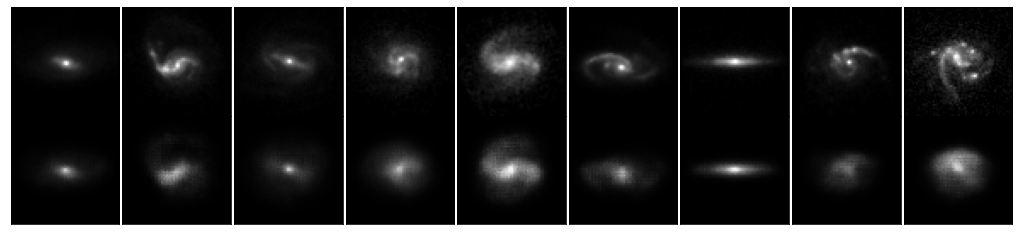

Maximal brightness 1.0


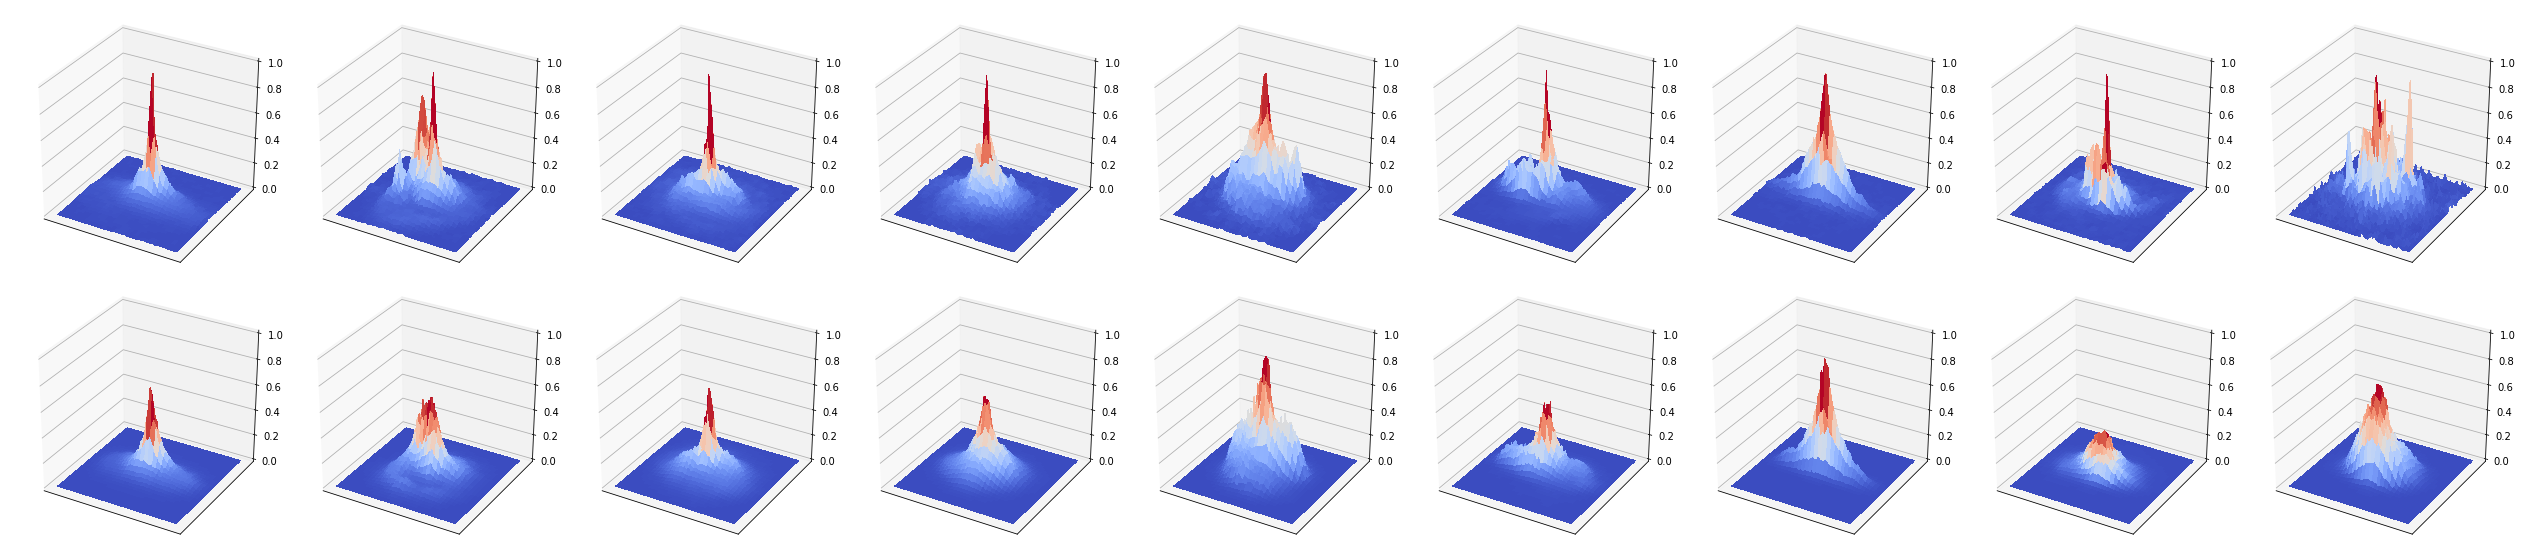

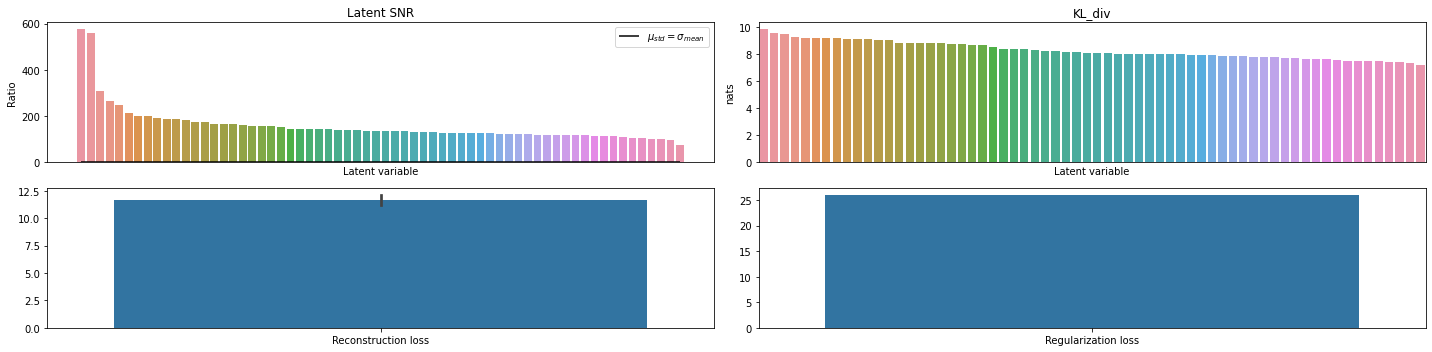

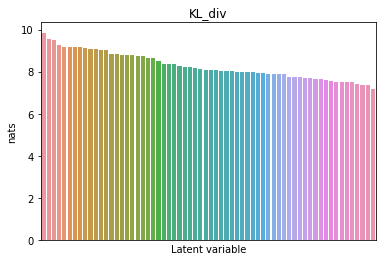

Controlled Capacity 510
Real Capacity 529.8506
Beta 0.049


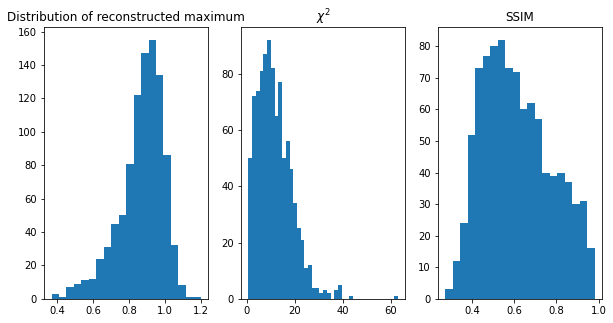

Max values RAE 0.137 ± 0.116, median 0.106
reduced chi^2 values 11.668 ± 7.229, median 10.413
SSIM values 0.615 ± 0.161, median 0.595


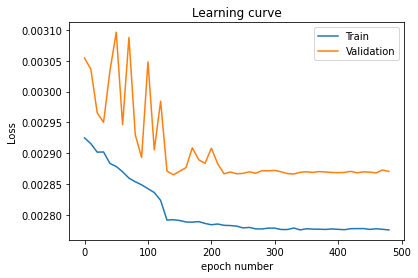

0 49 49


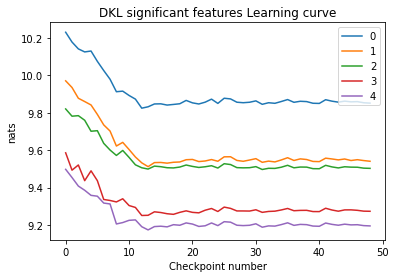

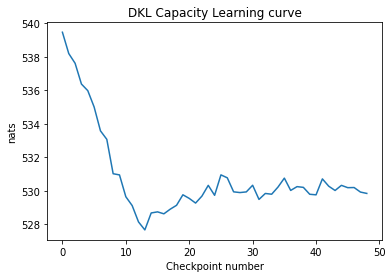

Epoch 51/900
 50/541 [=>............................] - ETA: 1:32 - loss: 0.0028

In [ ]:
_ = models['vae'].fit(x_train, x_train, shuffle=True, epochs=900,
        batch_size=batch_size,
        validation_data=(x_val, x_val),
        callbacks=[capacity_control,pltfig,lr_red],
        verbose=1)